<a href="https://colab.research.google.com/github/mirpouya/Transformer_EDU/blob/main/Vision_Transformer_pytorch_implementation_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### <b> Implementing the paper: "An image is worth 16*16 words: Transformers for image recognition at scale" </b>

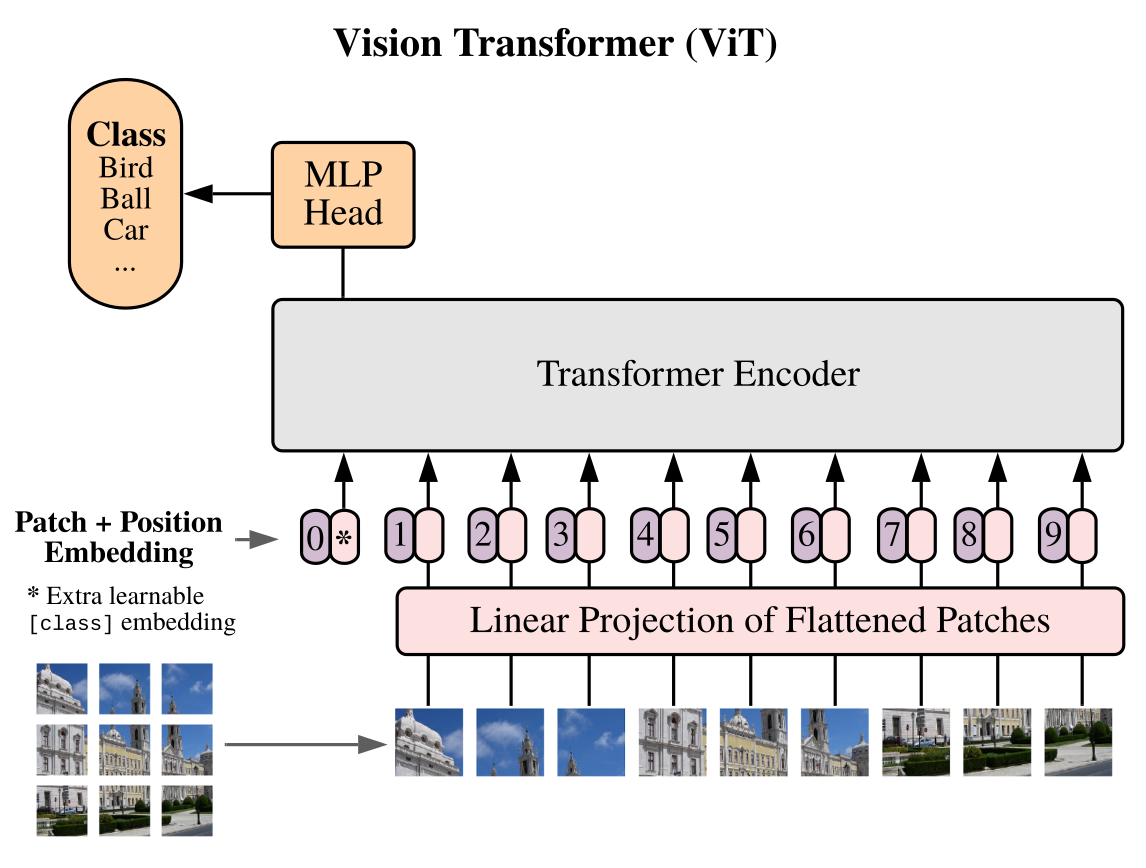

In [1]:
# importing required libraries

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
# from einops import rearrange, reduce, repeat
# from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary

A picture to test some stuff

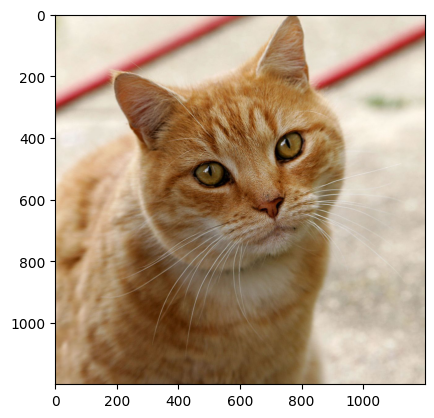

In [2]:
img = Image.open("/content/cat.jpg")

fig = plt.figure()
plt.imshow(img)

In [4]:
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce

ModuleNotFoundError: ignored

In [5]:
!pip3 install --force einops==0.4.1

In [6]:
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce

In [7]:
# resize to ImageNet size
img_transformer = Compose([Resize((224, 224)), ToTensor()])

img_tr = img_transformer(img)

# adding batch dim
img_tr = img_tr.unsqueeze(0)
img_tr.shape

torch.Size([1, 3, 224, 224])

## <b> Patches Embedding </b>

The first step is to device each image into patches, then flattening them into a vector.


The procedure is as follow:
we reshape each image of size (H, W, C) into a sequence of flattened 2D patches -> N * ( p^2, c )

In [8]:
# we want to device each 224*224 image into sub images of size 16*16
x = img_tr

patch_size = 16 # each sub image has 16 pixels width and height

patches = rearrange(x, 'b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size)

In [9]:
# now we pass these sub-images (patches) into a linear layer

class PatchEmbedding(nn.Module):

  def __init__(self, in_channels: int = 3, patch_size: int = 16, embed_size: int = 768):
    super().__init__()

    self.patch_size = patch_size

    # linear layer
    self.projection = nn.Sequential(
        # flatten sub-images (patches) to 16*16 vectors
        Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size),
        # 16*16 -> 768
        nn.Linear(patch_size * patch_size * in_channels, embed_size)
    )

    # overriding forward
  def forward(self, x: Tensor) -> Tensor:
    x = self.projection(x)

    return x

PatchEmbedding()(x).shape

torch.Size([1, 196, 768])

according to <a href="https://github.com/FrancescoSaverioZuppichini/ViT"> LINK </a> the author used a Conv2D instead of a linear layer for performing again

In [10]:
# Conv2D instead of linear layer

class PatchEmbedding(nn.Module):

  def __init__(self, in_channels: int = 3, patch_size: int = 16, embed_size: int = 768):
    super().__init__()

    self.patch_size = patch_size

    self.projection = nn.Sequential(
        # explain this to me
        nn.Conv2d(in_channels, embed_size, kernel_size = patch_size, stride = patch_size),
        Rearrange('b e (h) (w) -> b (h w) e')
    )

  def forward(self, x: Tensor) -> Tensor:
    x = self.projection(x)
    return x

PatchEmbedding()(x).shape

torch.Size([1, 196, 768])

## <b> Adding CLS tockens and Positional Embeddings </b>

In [11]:
class PatchEmbedding(nn.Module):

  def __init__(self, in_channels: int = 3, patch_size: int = 16, embed_size: int = 768):
    super().__init__()

    self.patch_size = patch_size

    self.projection = nn.Sequential(
        # Conv2d layer instead of linear layer
        nn.Conv2d(in_channels, embed_size, kernel_size = patch_size, stride = patch_size),
        Rearrange('b e (h) (w) -> b (h w) e')
    )

    self.cls_token = nn.Parameter(torch.randn(1, 1, embed_size))

  # forward method
  def forward(self, x: Tensor) -> Tensor:
    b, _, _, _ = x.shape
    x = self.projection(x)
    cls_tocken = repeat(self.cls_token, '() n e -> b n e', b=b)
    # concatenate cls_tockens to the x
    x = torch.cat([cls_tocken, x], dim = 1)
    return x

PatchEmbedding()(x).shape

torch.Size([1, 197, 768])

## <b> Positional Embedding </b>

In [12]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768, img_size: int = 224):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, emb_size))


    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        # prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1)
        # add position embedding
        x += self.positions
        return x

PatchEmbedding()(x).shape

torch.Size([1, 197, 768])

## <b> Transformer Block </b>

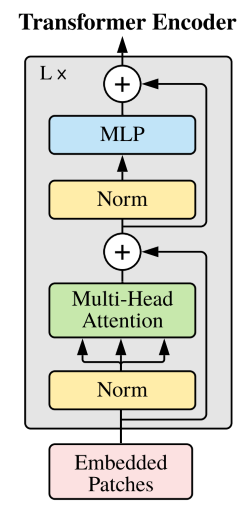

### <b> MultiHeadAttention </b>

In [13]:
class MultiHeadAttention(nn.Module):
  def __init__(self, embed_size: int = 768, n_heads: int = 8, dropout_rate: float = 0):
    super().__init__()

    self.embed_size = embed_size
    self.n_heads = n_heads
    self.scaling = (embed_size // n_heads) ** (-0.5)

    # we have 4 fully connected layers as weights: key, query, value for attention and a final projection

    self.key = nn.Linear(embed_size, embed_size)
    self.query = nn.Linear(embed_size, embed_size)
    self.value = nn.Linear(embed_size, embed_size)
    self.projection = nn.Linear(embed_size, embed_size)

    self.dropout = nn.Dropout(dropout_rate)

  # forward method
  def forward(self, x: Tensor, mask: Tensor = None) -> Tensor:
    """
    forward method takes values from previous layer, it takes key, query, value, since all of the three are the same
    I passed all of them as 'x'
    Because we have multiple heads, I rearaged the key, query, values in multiple heads
    """
    # split key, query, value in multi-attention-heads
    query = rearrange(self.query(x), "b n (h d) -> b h n d", h=self.n_heads)
    key = rearrange(self.key(x), "b n (h d) -> b h n d", h=self.n_heads)
    value  = rearrange(self.value(x), "b n (h d) -> b h n d", h=self.n_heads)

    """
    The resulting key, query, value have a shape of (batch, heads, sequence_len, embedding_size)

    For computing attention matrice, we have to perform matrix multiplication between queries and keys, then sum them up over the last axis
    this is done by `torch.einsum(.)`
    """
    energy = torch.einsum('bhqd, bhkd -> bhqk', query, key) # batch, num_heads, query_len, key_len
    # this resulting matric 'energy' has the shape (batch, heads, query_len, key_len)

    if mask is not None:
      fill_value = torch.finfo(torch.float32).min
      energy.mask_fill(~mask, fill_value)

    attention = F.softmax(energy, dim = -1)
    attention = self.dropout(attention)

    # sum according to the third axis
    # attention heads multiplied by value together
    out = torch.einsum("bhal, bhlv -> bhav", attention, value)

    # rearanging dimensions to concat the heads
    out = rearrange(out, "b h n d -> b n (h d)")
    # passing throug linear layer
    out = self.projection(out)
    return out

patches_embedded = PatchEmbedding()(x)
MultiHeadAttention()(patches_embedded).shape

torch.Size([1, 197, 768])

##  We can better arrange <b> `Multi-Head-Attention` </b> by using a single matrix

In [14]:
class MultiHeadAttentin(nn.Module):
  def __init__(self, embed_size: int = 768, n_heads: int = 8, dropout_rate: float = 0.2):
    super().__init__()

    self.embed_size = embed_size
    self.n_heads = n_heads

    # merge key, query, value matrices into one matrix
    self.qkv = nn.Linear(embed_size, embed_size * 3)
    self.dropout = nn.Dropout(dropout_rate)
    self.projection = nn.Linear(embed_size, embed_size)

  def forward(self, x : Tensor, mask : Tensor = None) -> Tensor:
    # split key, query, value into heads
    qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
    queries, keys, values = qkv[0], qkv[1], qkv[2]

    # sum up over the last axis
    energy = torch.einsum("bhqd, bhkd -> bhqk", queries, keys) # (batch_size, n_heads, query_len, key_len)

    if mask is not None:
      fill_value = torch.finfo(torch.float32).min
      energy.mask_fill(~mask, fill_value)

    # scale factor
    scaling = (self.embed_size) ** (0.5)
    att = F.softmax(energy, dim=-1) / scaling
    att_drop = self.dropout(att)

    # sum over the third axis
    out = torch.einsum('bhal, bhlv -> bhav ', att, values)
    out = rearrange(out, "b h n d -> b n (h d)")
    out = self.projection(out)

    return out

patches_embedded = PatchEmbedding()(x)
MultiHeadAttention()(patches_embedded).shape

torch.Size([1, 197, 768])

### <b> Residuals adds to the output of MultiHeadAttention </b>

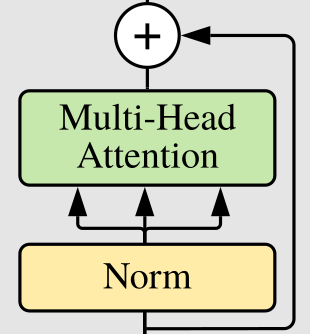

In [15]:
class ResidualAdd(nn.Module):
  def __init__(self, fn):
    super().__init__()
    self.fn = fn

  def forward(self, x, **kwargs):
    res = x
    x = self.fn(x, **kwargs)
    x += res
    return x

## <b> MLP Block </b>

In [16]:
"""
class MLPForward(nn.Sequential):
  def __init__(self, embed_size: int = 768, expansion_factor: int = 4, dropout_rate: float = 0.):
    super().__init__(
        nn.Linear(embed_size, expansion_factor * embed_size),
        nn.GELU(),
        nn.Dropout(dropout_rate),
        nn.Linear(expansion_factor * embed_size, embed_size)
    )  """

class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

Inheriting from `nn.Sequential` allows us not to write forward method

## <b> Transformer Block </b>

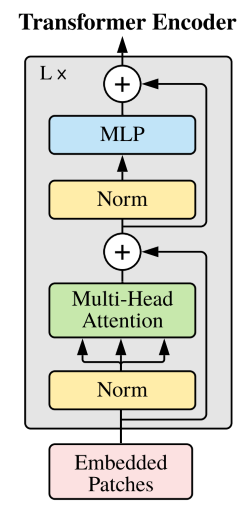

In [17]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 768,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))

In [18]:
patches_embedded = PatchEmbedding()(x)
TransformerEncoderBlock()(patches_embedded).shape

torch.Size([1, 197, 768])

## <b> Stack of Transformers </b>

In [19]:
class TransformerEncoders(nn.Sequential):
  def __init__(self, depth: int = 12, **kwargs):
    super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

## <b> Classificatoin Head </b>

classfificatin head is a fully connected layer which calculated each class probability

In [20]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 768, n_classes: int = 1000):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, n_classes))

## <b> Vision Transformer Model </b>

In [24]:
class ViT(nn.Sequential):
    def __init__(self,
                in_channels: int = 3,
                patch_size: int = 16,
                emb_size: int = 768,
                img_size: int = 224,
                depth: int = 12,
                n_classes: int = 1000,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoders(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )

In [25]:
summary(ViT(), (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
         Rearrange-2             [-1, 196, 768]               0
    PatchEmbedding-3             [-1, 197, 768]               0
         LayerNorm-4             [-1, 197, 768]           1,536
            Linear-5             [-1, 197, 768]         590,592
            Linear-6             [-1, 197, 768]         590,592
            Linear-7             [-1, 197, 768]         590,592
           Dropout-8          [-1, 8, 197, 197]               0
            Linear-9             [-1, 197, 768]         590,592
MultiHeadAttention-10             [-1, 197, 768]               0
          Dropout-11             [-1, 197, 768]               0
      ResidualAdd-12             [-1, 197, 768]               0
        LayerNorm-13             [-1, 197, 768]           1,536
           Linear-14            [-1, 1